# Activation rate estimation

## Setup

### Imports

In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sys
import time

%matplotlib inline

In [2]:
sys.path.append('../../../stationsim/')
from stationsim_gcs_model import Model

### Functions

In [3]:
def data_checks(df):
    print(f'Shape: {df.shape}')
    print('Basic info:')
    print(df.info())
    print('Basic statistical description:')
    print(df.describe())

In [4]:
def get_number_pedestrians_in_frame(df, frame):
    tdf = df.loc[df['frame']==frame, :]
    return len(tdf['pedestrianID'].unique())

In [5]:
def make_hist(data, xlabel):
    plt.figure()
    plt.hist(data, bins=20, density=True)
    sns.kdeplot(data)
    plt.xlabel(xlabel)
    plt.ylabel('Density')
    plt.show()

In [6]:
def __get_error(observed, model, variable):
    return observed[variable] - model[variable]

In [7]:
def get_error(observed_results, model_results):
    n_max_peds = __get_error(observed_results, model_results, 'n_max_active_pop')
    t_max_peds = __get_error(observed_results, model_results, 't_max_active_pop')
    t_max = __get_error(observed_results, model_results, 't_max')
    
    results = {'n_max_active_pop': n_max_peds,
               't_max_active_pop': t_max_peds,
               't_max': t_max,
               'rate': model_results['rate']}
    return results

### Constants

In [8]:
IS_INSTANTANEOUS = False

### Paths and directories

In [9]:
combined_frames_path = '../outputs/combined_frames.csv'

In [10]:
fig_dir = '../outputs/figures/activation_rate/'

In [11]:
output_data_dir = '../outputs/data/'

### Reading in data

In [12]:
data = pd.read_csv(combined_frames_path)
data_checks(data)

Shape: (226390, 4)
Basic info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226390 entries, 0 to 226389
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   frame         226390 non-null  int64  
 1   pedestrianID  226390 non-null  int64  
 2   x             226390 non-null  float64
 3   y             226390 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 6.9 MB
None
Basic statistical description:
               frame   pedestrianID              x              y
count  226390.000000  226390.000000  226390.000000  226390.000000
mean     2470.663850     155.137179     392.602947     354.959243
std      1016.745355      74.562383     180.821820     192.724098
min         0.000000       0.000000       0.273183       0.437440
25%      1638.000000     100.000000     241.066288     195.457077
50%      2390.000000     158.000000     403.850970     356.881671
75%      3254.000000     224.000000     535.001

## Analysis

### Number of pedestrians recorded

By considering the unique pedestrian IDs, we can see how many pedestrians pass through the system over the time recorded by the camera.

In [13]:
data['pedestrianID'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,  30,  31,  32,  33,  69,
        78,  79,  80,  83,  84,  86,  88,  97, 108, 111, 112, 114, 115,
       118, 120, 121, 122, 123, 124, 125, 126, 127, 131, 132, 136, 147,
       156, 157, 159, 161, 163, 164, 165, 166, 167, 168, 169, 170, 171,
       172, 173, 174, 233, 243, 245, 246, 247, 248, 250, 251, 199, 208,
        13,  16,  18,  19,  87,  90,  91,  92,  93,  94,  95, 128, 129,
       130, 148, 149, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184,
       185, 186, 249, 252, 253, 254, 255, 256, 257, 258, 259, 261, 264,
       267,  20,  21,  22,  23,  40,  41,  42,  43,  44,  45,  46,  47,
        48,  49,  50, 133, 134, 137, 139, 143, 150, 151, 187, 188, 189,
       190, 192, 195, 197, 198, 200, 201, 202, 203, 204, 205, 206, 207,
       209, 210, 211, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222,
       223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 235, 236, 237,
         9,  10,  11,  12,  34,  35,  36,  37,  38,  89, 269, 19

In [14]:
len(data['pedestrianID'].unique())

274

There are $274$ unique pedestrian IDs, therefore, there are $274$ different pedestrians who pass through the system.
This number is may be impacted by the process used to join up partial trajectories.

### Variation in number of pedestrians in system over time

In [15]:
frame_numbers = data['frame'].unique()
pedestrians_per_frame = list()
for frame_number in frame_numbers:
    d = {'frame': frame_number,
         'n_pedestrians': get_number_pedestrians_in_frame(data, frame_number)}
    pedestrians_per_frame.append(d)

pedestrians_per_frame = pd.DataFrame(pedestrians_per_frame)
data_checks(pedestrians_per_frame)

Shape: (5688, 2)
Basic info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5688 entries, 0 to 5687
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   frame          5688 non-null   int64
 1   n_pedestrians  5688 non-null   int64
dtypes: int64(2)
memory usage: 89.0 KB
None
Basic statistical description:
             frame  n_pedestrians
count  5688.000000    5688.000000
mean   2843.500000      39.801336
std    1642.128497      29.983213
min       0.000000       1.000000
25%    1421.750000       7.000000
50%    2843.500000      50.000000
75%    4265.250000      69.000000
max    5687.000000      85.000000


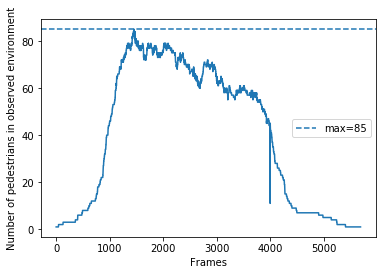

In [16]:
plt.figure()
sns.lineplot(x='frame', y='n_pedestrians', data=pedestrians_per_frame)
plt.axhline(85, linestyle='--', label='max=85')
plt.xlabel('Frames')
plt.ylabel('Number of pedestrians in observed environment')
plt.legend()
plt.savefig(fig_dir + 'pedestrians_in_system.pdf')
plt.show()

#### Rescaling time to seconds

In [17]:
pedestrians_per_frame['time'] = pedestrians_per_frame['frame'] / 25

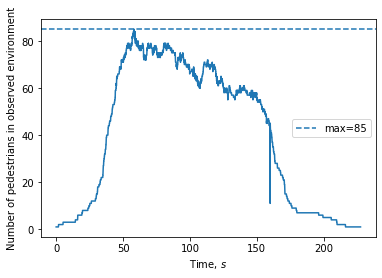

In [18]:
plt.figure()
sns.lineplot(x='time', y='n_pedestrians', data=pedestrians_per_frame)
plt.axhline(85, linestyle='--', label='max=85')
plt.xlabel('Time, $s$')
plt.ylabel('Number of pedestrians in observed environment')
plt.legend()
plt.savefig(fig_dir + 'pedestrians_in_system_rescaled.pdf')
plt.show()

### Distribution of number pedestrians

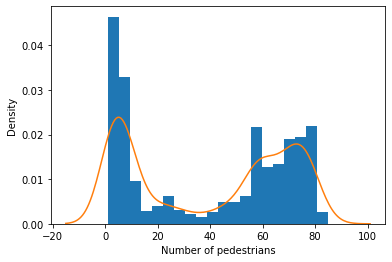

In [19]:
make_hist(pedestrians_per_frame['n_pedestrians'],
          'Number of pedestrians')

## Testing with model

Having reviewed how the number of pedestrians in the system varies at any given time, we can compare this behaviour wtih the behaviour exhibitted by the model for different activation rates.
To do this, we use the other paramters found so far:
* Pedestrian speed - `mean`, `std`, `min`
* Number of pedestrian in system

### Converting units

The model is designed to reflect the system on a pixel and frame basis instead of on a metre and second basis.
We, therefore, need to rescale pedestrian speeds to `pixels/frame`.
This can be achieved by dividing by the scaling factor $\frac{25}{14}$.

In [20]:
scaling_factor = 25/14

In [21]:
# Average speed
average_speed = {'mean': 1.6026400144010877 / scaling_factor,
                 'std': 0.6642343305178546 / scaling_factor,
                 'min': 0.31125359137714953 / scaling_factor}

average_speed

{'mean': 0.8974784080646091,
 'std': 0.3719712250899986,
 'min': 0.17430201117120372}

In [22]:
# Average instantaneous speed
average_instantaneous_speed = {'mean': 2.6293949608344023 / scaling_factor,
                               'std': 0.6858768896844895 / scaling_factor,
                               'min': 0.4461755142533113 / scaling_factor}

average_instantaneous_speed

{'mean': 1.4724611780672652,
 'std': 0.3840910582233141,
 'min': 0.24985828798185433}

In [23]:
speed = average_instantaneous_speed if IS_INSTANTANEOUS else average_speed

### Setting up parameters

In [24]:
model_params = {'station': 'Grand_Central',
                'speed_mean': speed['mean'],
                'speed_std:': speed['std'],
                'speed_min': speed['min'],
                'step_limit': 20000,
                'do_print': False,
                'pop_total': 274}

In [25]:
activation_rates = [i / 10 for i in range(10, 21)]

### Observed values for errors

Calculate values from the data for the following:
* The maximum number of pedestrian in the system at any one time,
* The time at which this maximum occurs, and
* The time at which all pedestrians have completed their trajectories.

In [26]:
# Maximum number of pedestrians in the system at any one time
max_n_peds = max(pedestrians_per_frame['n_pedestrians'])
max_n_peds

85

In [27]:
# Time at which the maximum number of pedestrians in the sytem occurs
max_peds_frames = pedestrians_per_frame.loc[pedestrians_per_frame['n_pedestrians']==max_n_peds, 'frame']
t_max_n_peds = np.mean(max_peds_frames)
t_max_n_peds

1454.0

In [28]:
# Time at which all pedestrians have completed their trajectories
end_frame = max(pedestrians_per_frame['frame'])
end_frame

5687

In [29]:
# Show that we don't have multiple pedestrians in the system at this point
final_frame = pedestrians_per_frame.loc[pedestrians_per_frame['frame']==end_frame, :]
final_frame

,frame,n_pedestrians,time
3037,5687,1,227.48


### Running model to generate results

In [30]:
results = list()
errors = list()
run_count = 0

data_results = {'n_max_active_pop': max_n_peds,
                't_max_active_pop': t_max_n_peds,
                't_max': end_frame}

for rate in activation_rates:
    model_params['birth_rate'] = rate
    for i in range(20):
        if run_count % 10 == 1:
            print('Taking a quick break')
            time.sleep(30)
        print(f'Running iteration {i} of rate={rate}')
        # Run model and collect results
        model = Model(**model_params)
        
        n_max_active_pop = 0
        t_max_active_pop = 0
        t_max = False
        
        for _ in range(20000):
            model.step()
            timestep_results = {'frame': model.step_id,
                                'active_pedestrians': model.pop_active,
                                'rate': rate}
            results.append(timestep_results)
            
            # Update max_active_pop
            if model.pop_active > n_max_active_pop:
                n_max_active_pop = model.pop_active
                t_max_active_pop = model.step_id
            
            # get t_max
            if not t_max and model.step_id > 1000 and model.pop_active == 1:
                t_max = model.step_id

        model_results = {'n_max_active_pop': n_max_active_pop,
                         't_max_active_pop': t_max_active_pop,
                         't_max': t_max,
                         'rate': rate}
        
        model_errors = get_error(data_results, model_results)
        errors.append(model_errors)
        run_count += 1

Running iteration 0 of rate=1.0


../../../stationsim/stationsim_gcs_model.py:573: RuntimeWarning: speed_std: is not a model parameter.
  warnings.warn(f'{key} is not a model parameter.',


Taking a quick break
Running iteration 1 of rate=1.0
Running iteration 2 of rate=1.0
Running iteration 3 of rate=1.0
Running iteration 4 of rate=1.0
Running iteration 5 of rate=1.0
Running iteration 6 of rate=1.0
Running iteration 7 of rate=1.0
Running iteration 8 of rate=1.0
Running iteration 9 of rate=1.0
Running iteration 10 of rate=1.0
Taking a quick break
Running iteration 11 of rate=1.0
Running iteration 12 of rate=1.0
Running iteration 13 of rate=1.0
Running iteration 14 of rate=1.0
Running iteration 15 of rate=1.0
Running iteration 16 of rate=1.0
Running iteration 17 of rate=1.0
Running iteration 18 of rate=1.0
Running iteration 19 of rate=1.0
Running iteration 0 of rate=1.1
Taking a quick break
Running iteration 1 of rate=1.1
Running iteration 2 of rate=1.1
Running iteration 3 of rate=1.1
Running iteration 4 of rate=1.1
Running iteration 5 of rate=1.1
Running iteration 6 of rate=1.1
Running iteration 7 of rate=1.1
Running iteration 8 of rate=1.1
Running iteration 9 of rate=1.1

Number of pedestrians in system over time

In [31]:
with open(output_data_dir + 'population_trajectories_average.json', 'w') as f:
    json.dump(results, f)

In [32]:
results = pd.DataFrame(results)
results.head()

,frame,active_pedestrians,rate
0,1,0,1.0
1,2,1,1.0
2,3,1,1.0
3,4,1,1.0
4,5,1,1.0


In [33]:
results['active_pedestrians'].unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116])

Errors

In [34]:
with open(output_data_dir + 'errors_average.json', 'w') as f:
    json.dump(errors, f)

In [36]:
errors = pd.DataFrame(errors)
errors.head()

,n_max_active_pop,t_max_active_pop,t_max,rate
0,27,-4773.0,-4154,1.0
1,30,-2323.0,-3516,1.0
2,27,-4622.0,-3544,1.0
3,23,-3148.0,-3814,1.0
4,28,-4672.0,-3266,1.0


### Processing results

* Facet grid
* Each grid element contains a graph of number of pedestrian in the system for a given time; solid line from data, dashed line with CI from simulations

In [34]:
with open(output_data_dir + 'population_trajectories_average.json', 'r') as f:
    results = json.load(f)
results = pd.DataFrame(results)
results.head()

,frame,active_pedestrians,rate
0,1,0,1.0
1,2,1,1.0
2,3,1,1.0
3,4,1,1.0
4,5,1,1.0


In [35]:
with open(output_data_dir + 'errors_average.json', 'r') as f:
    errors = json.load(f)
errors = pd.DataFrame(errors)
errors.head()

,n_max_active_pop,t_max_active_pop,t_max,rate
0,27,-4773.0,-4154,1.0
1,30,-2323.0,-3516,1.0
2,27,-4622.0,-3544,1.0
3,23,-3148.0,-3814,1.0
4,28,-4672.0,-3266,1.0


Filtering out frames from our model results in which there are no active pedestrians.

In [36]:
results = results.loc[results['active_pedestrians']!=0, :]
results.head()

,frame,active_pedestrians,rate
1,2,1,1.0
2,3,1,1.0
3,4,1,1.0
4,5,1,1.0
5,6,1,1.0


#### Visualising the number of pedestrians in system

1.0 (198024, 3)


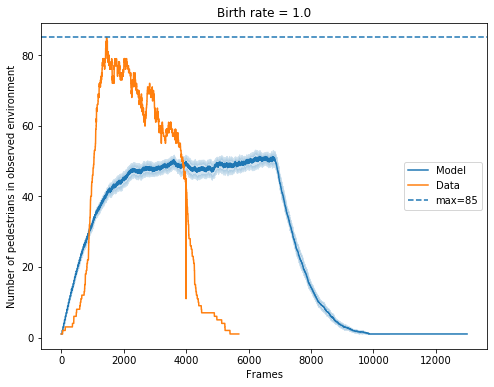

1.1 (202881, 3)


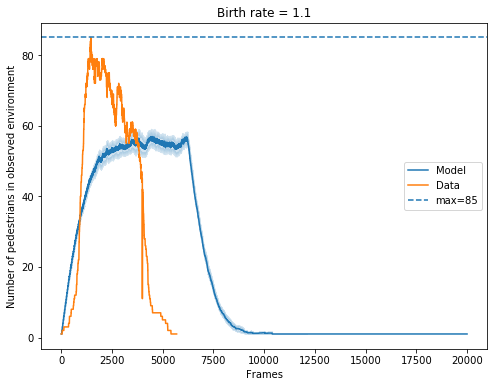

1.2 (209612, 3)


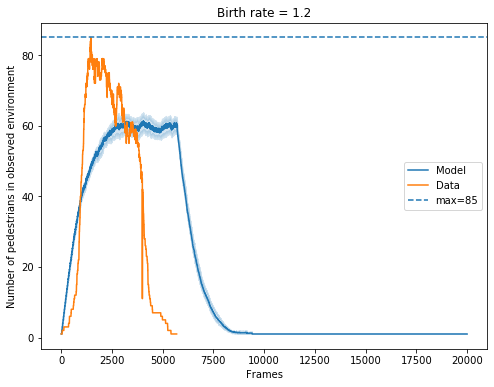

1.3 (215446, 3)


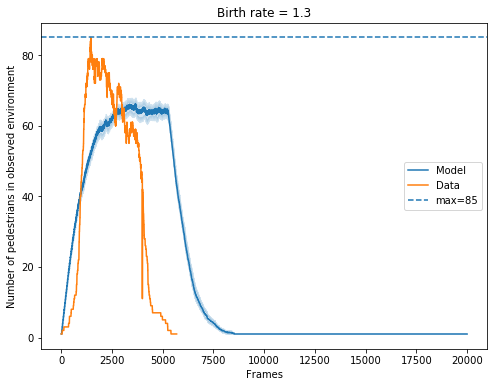

1.4 (203003, 3)


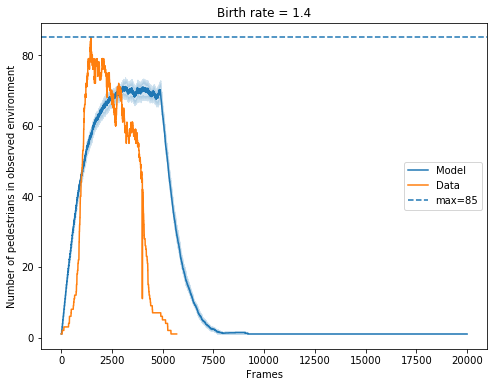

1.5 (225815, 3)


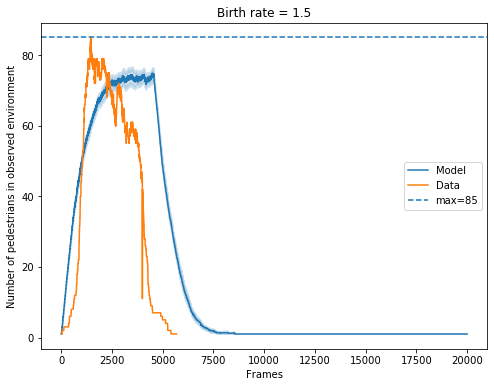

1.6 (169152, 3)


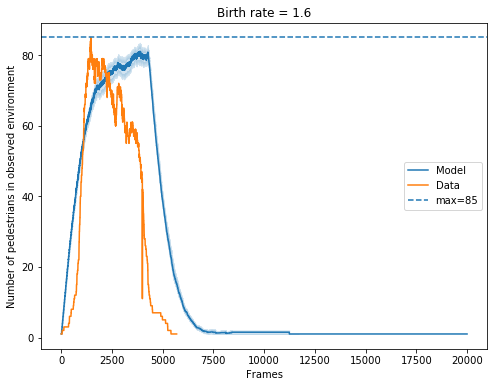

1.7 (184130, 3)


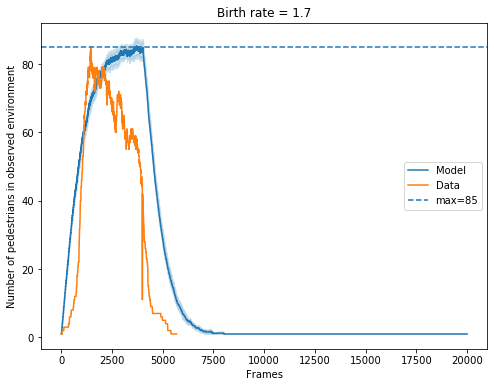

1.8 (178736, 3)


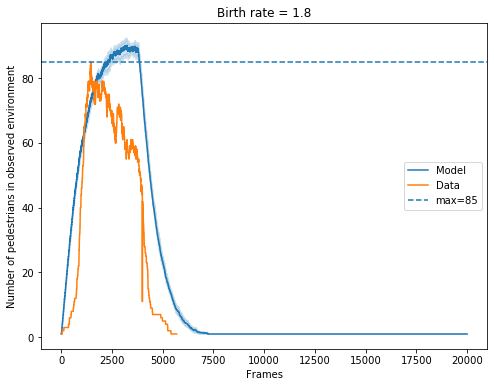

1.9 (194182, 3)


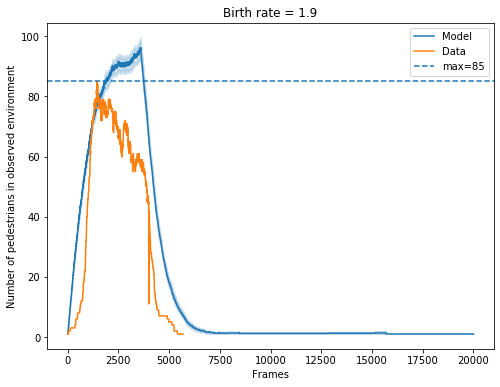

2.0 (194546, 3)


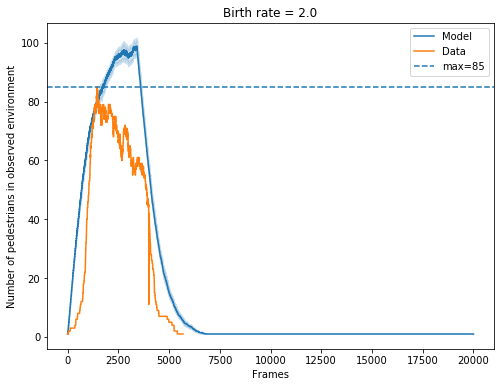

In [37]:
for rate in activation_rates:
    df = results.loc[results['rate']==rate, :]
    print(rate, df.shape)
    plt.figure(figsize=(8, 6))
    sns.lineplot(data=df, x='frame', y='active_pedestrians', label='Model')
    sns.lineplot(x='frame', y='n_pedestrians', data=pedestrians_per_frame, label='Data')
    plt.axhline(85, linestyle='--', label='max=85')
    plt.xlabel('Frames')
    plt.ylabel('Number of pedestrians in observed environment')
    plt.legend()
    plt.title(f'Birth rate = {rate}')
    r = str(rate).replace('.', '_')
    plt.savefig(fig_dir + f'activation_rate_average_{r}.pdf')
    plt.show()

#### Visualising errors

In [38]:
def make_ridge_plot(data, categorical_var, continuous_var):
    # Ridge plot for error in t_max
    sns.set_theme(rc={'axes.facecolor': (0, 0, 0, 0)})

    # Initialise facegrid
    g = sns.FacetGrid(data, row=categorical_var, hue=categorical_var,
                      aspect=15, height=0.5)

    # Draw densities
    g.map(sns.kdeplot, continuous_var,
          bw_adjust=0.5, clip_on=False,
          fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, continuous_var, clip_on=False, color='w', lw=2, bw_adjust=0.5)
    g.map(plt.axhline, y=0, lw=2, clip_on=False)


    # Function to label plots
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, 0.2, label, color=color,
                ha='left', va='center', transform=ax.transAxes)


    g.map(label, continuous_var)

    # Set plots to overlap
    g.fig.subplots_adjust(hspace=0.25)

    # Remove axes details that don't work with overlap
    g.set_titles('')
    g.set(yticks=[])
    g.despine(bottom=True, left=True)
    plt.show()
    return g

/home/keiran/miniconda3/envs/dust/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/home/keiran/miniconda3/envs/dust/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


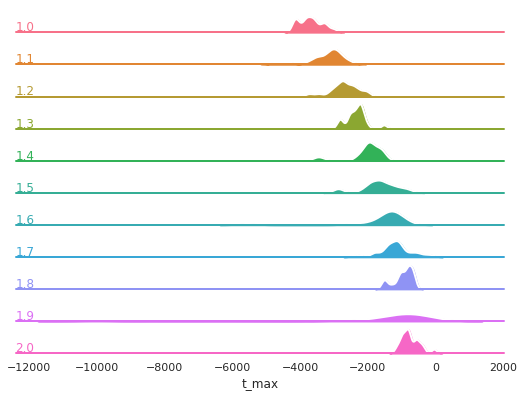

In [39]:
f = make_ridge_plot(errors, 'rate', 't_max')

In [40]:
f.savefig(fig_dir + 't_max_error_average_ridge.pdf')

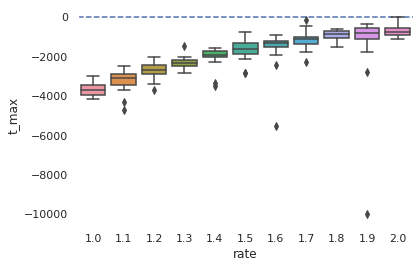

<Figure size 432x288 with 0 Axes>

In [41]:
plt.figure()
plt.axhline(0, linestyle='--')
sns.boxplot(x='rate', y='t_max', data=errors)
plt.show()
plt.savefig(fig_dir + 't_max_error_average_box.pdf')

/home/keiran/miniconda3/envs/dust/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/home/keiran/miniconda3/envs/dust/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


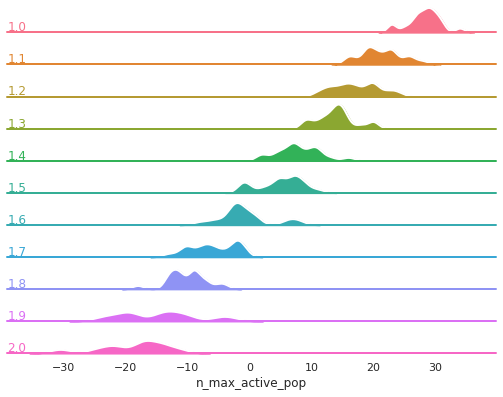

In [42]:
f = make_ridge_plot(errors, 'rate', 'n_max_active_pop')

In [43]:
f.savefig(fig_dir + 'n_max_active_pop_error_average_ridge.pdf')

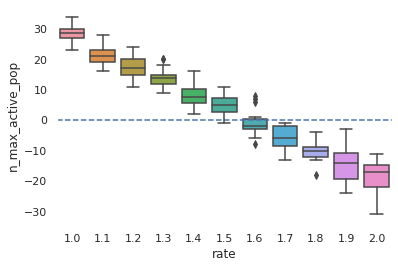

<Figure size 432x288 with 0 Axes>

In [44]:
plt.figure()
plt.axhline(0, linestyle='--')
sns.boxplot(x='rate', y='n_max_active_pop', data=errors)
plt.show()
plt.savefig(fig_dir + 'n_max_active_pop_error_average_box.pdf')

/home/keiran/miniconda3/envs/dust/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/home/keiran/miniconda3/envs/dust/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


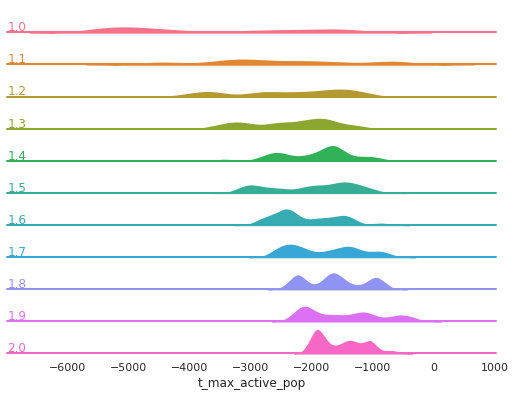

In [45]:
f = make_ridge_plot(errors, 'rate', 't_max_active_pop')

In [46]:
f.savefig(fig_dir + 't_max_active_pop_error_average_ridge.pdf')

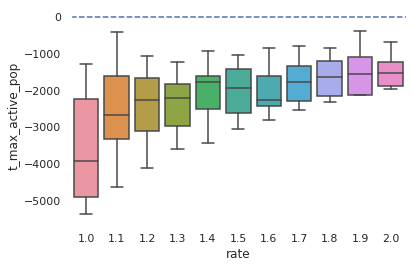

<Figure size 432x288 with 0 Axes>

In [47]:
plt.figure()
plt.axhline(0, linestyle='--')
sns.boxplot(x='rate', y='t_max_active_pop', data=errors)
plt.show()
plt.savefig(fig_dir + 't_max_active_pop_error_average_box.pdf')